# Title


# Introduction

Bike share programs are a type of shared public transporatation system that is considered to be eco-friendly and sustainable. Typically these systems work by allowing people to rent bikes at a station, travel to their destination, and return the bike to another station. Such bike programs are frequently implemented in more densly populated areas such as cities, and have been relatively successful. Majority of revenue is from bike users and the time they borrow a bike. This leads to the question: what factors influences the number of bike trips? Knowing this can allow us to see what business strategies can be used to optimize the conditions in which people use bike share programs and potentially incentivize people to use these more.


## Libraries

In [1]:
import sqlite3
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np

## Importing Data
To analyze this, we can first obtain some sample data from a bike share program 

In [2]:
# read csv

In [3]:
station = pd.read_csv("station.csv")
trip = pd.read_csv("trip.csv")
weather = pd.read_csv("weather.csv")

In [4]:
# Columns in each table
station # id, name, lat, long, dock_count, city, installation_date
trip 
"""(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'zip_code'],
      dtype='object')"""
weather 
""" (['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code'],
      dtype='object')"""


" (['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',\n       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',\n       'max_humidity', 'mean_humidity', 'min_humidity',\n       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',\n       'min_sea_level_pressure_inches', 'max_visibility_miles',\n       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',\n       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',\n       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code'],\n      dtype='object')"

## Data Cleaning and Manipulation (reword me)

In [5]:
# Clean for missing data
station.dropna()
trip.dropna()
weather.dropna()

# remove any outlier where someone used bike over the 2 years duration 1,7270,400   1,051,200
# max_time = 24 * 60
# trip = trip[trip.duration <= max_time]

# Convert dates from string to datetime objects
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
weather['date'] = pd.to_datetime(weather['date'])

# Binning by month using the start date
trip['month'] = trip['start_date'].apply(lambda x: x.month)

# Clean for missing data (drop rows with missing data)


## Data Exploration

To get a better understanding of the bike program, we can first map out the location of all stations. It appears there are 3 clusters

In [6]:
trip['duration'].max()

17270400

In [7]:
# mark all the stations
map_osm = folium.Map(location=[37.60, -122.29], zoom_start=9)

for index, station_info in station.iterrows():
    tooltip_text = station_info['name'] + "\n"
    folium.Marker(location=[station_info["lat"], station_info["long"]], tooltip=tooltip_text).add_to(map_osm)
    
map_osm

In [8]:
# comparison of number of start and end trips at each station

# Summary stats


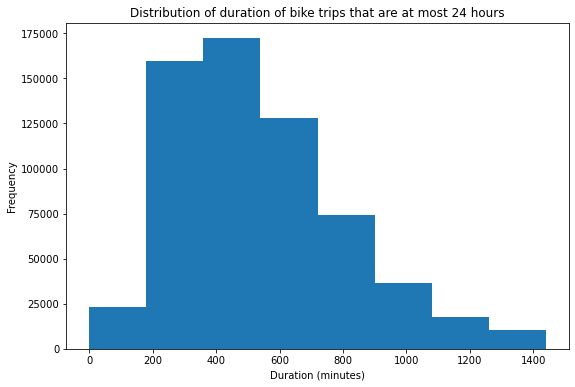

In [9]:
# histogram of the biking time duration for trips of length 1 day
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.hist(trip['duration'], bins = 8, range=[0, 24 * 60])

# Graph labels and titles
plt.title('Distribution of duration of bike trips that are at most 24 hours')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

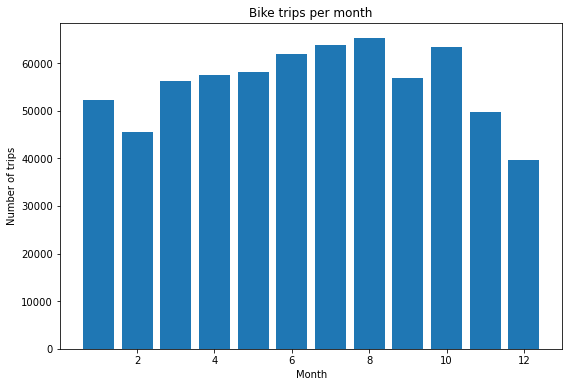

In [10]:
# number of bike trips per month
# Label points and change plot size
fig, ax = plt.subplots(figsize = (9, 6))
plt.bar(range(1, 13), np.bincount(trip['month'], minlength=13)[1:])

# Graph labels and titles
plt.title('Bike trips per month')
plt.xlabel('Month')
plt.ylabel('Number of trips')
plt.show()


Text(0.5, 1.0, 'Violin Plot Example')

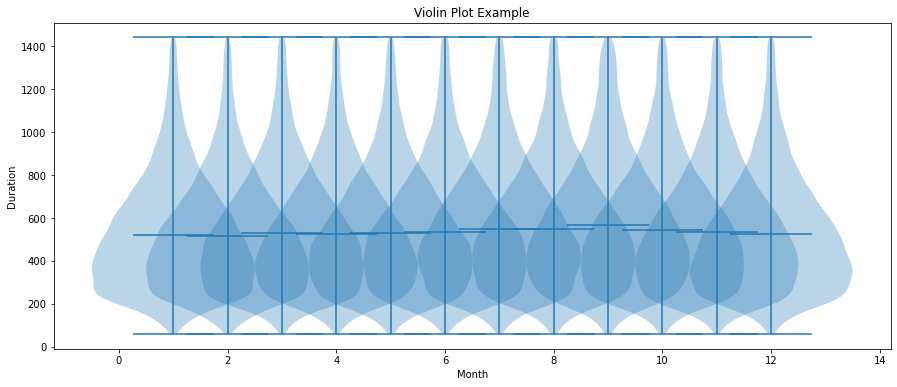

In [19]:
# Show distribution of bike duration per month via violin plots
# Violin Plot

max_time = 24 * 60
trip_v1 = trip[trip.duration <= max_time]
def extract_duration_data_by_month(month):
        return (trip_v1.loc[trip_v1['month'] == month])['duration']

data_jan = extract_duration_data_by_month(1)
data_feb = extract_duration_data_by_month(2)
data_mar = extract_duration_data_by_month(3)
data_apr = extract_duration_data_by_month(4)
data_may = extract_duration_data_by_month(5)
data_jun = extract_duration_data_by_month(6)
data_jul = extract_duration_data_by_month(7)
data_aug = extract_duration_data_by_month(8)
data_sep = extract_duration_data_by_month(9)
data_oct = extract_duration_data_by_month(10)
data_nov = extract_duration_data_by_month(11)
data_dec = extract_duration_data_by_month(12)
duration_per_month = [
    data_jan,
    data_feb,
    data_mar,
    data_apr,
    data_may,
    data_jun,
    data_jul,
    data_aug,
    data_sep,
    data_oct,
    data_nov,
    data_dec]

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

fig, ax = plt.subplots(figsize = (15, 6)) 

ax.violinplot(duration_per_month, months, widths=3, showmeans=True)
ax.set_xlabel("Month")
ax.set_ylabel("Duration")
ax.set_title("Violin Plot Example")

## Data Analysis and Hypothesis Testing

## Predicting [something] with Machine Learning

In [11]:
# regression with weather and number of bike rides

## Conclusion